# calculates the seasonal anomalies and the seasonal percentile categories from the gridded VCSN monthly files, using the NZ 6 regions masks and the [regionmask](https://regionmask.readthedocs.io/) library

### enter the variable name here 

In [ ]:
var_name = 'Rain_bc'
# var_name = 'Tmin_N'
# var_name = 'Tmax_N'
# var_name = 'Tmean_N'
# var_name = 'SoilM'
# var_name = 'Wind'
# var_name = 'Rad'

variable name should be in:  

+ original VCSN variables:  

['MSLP', 'PET', 'Rain', 'RH', 'SoilM',
       'ETmp', 'Rad', 'TMax', 'Tmin', 'VP', 'Wind', 'Rain_bc', 'Tmax_N',
       'Tmin_N'] 

or: 

+ derived variables: 

    + Tmean:  (Tmin + Tmax) / 2 
    + Tmean_N: (Tmin_N + Tmax_N) / 2 )

In [ ]:
import os
import sys
import pathlib

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from itertools import product

In [4]:
import salem
import geopandas as gpd

In [5]:
import xarray as xr

### path definitions 

In [6]:
HOME = pathlib.Path.home()

In [7]:
CWD = pathlib.Path.cwd() 

### path to the mask dataset (for regionmask)

In [8]:
mask_path = pathlib.Path('/media/nicolasf/END19101/data/VCSN/')

### path to the VCSN data 

In [9]:
vcsn_path = HOME.joinpath(f'operational/VCSN/data/NC/MONTHLY/{var_name.upper()}')

### output path root for the CSV files 

In [10]:
csv_path = HOME.joinpath("research/Smart_Ideas/outputs/targets/NZ_regions/NZ_6_regions")

### function to calculate the anomalies with respect to the 1981 - 2010 climatology 

In [11]:
def demean(x): 
    return x - x.loc['1981':'2010',].mean()

### big_var is the simplified version of the variable, so Rain_bc --> RAIN, Tmin_N --> TMIN ...

In [12]:
big_var = var_name.split('_')[0].upper()

In [13]:
HOME = pathlib.Path.home()

### open the VCSN monthly dataset 

In [14]:
vcsn_path

PosixPath('/home/nicolasf/operational/VCSN/data/NC/MONTHLY/RAIN_BC')

In [15]:
dset = xr.open_dataset(vcsn_path.joinpath(f'VCSN_gridded_{var_name}_1979-01_2019-12.nc')) 

In [16]:
dset

<xarray.Dataset>
Dimensions:  (lat: 257, lon: 241, time: 492)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2019-12-31
  * lon      (lon) float64 166.5 166.5 166.6 166.6 ... 178.3 178.4 178.4 178.5
  * lat      (lat) float64 -47.27 -47.23 -47.17 -47.12 ... -34.52 -34.48 -34.42
Data variables:
    Rain_bc  (time, lat, lon) float64 ...
    agent    (lat, lon) float32 ...
    mask     (lat, lon) float64 ...

### calculates the seasonal average (or sum if rainfall ..)

In [17]:
if "Rain" in var_name: 
    dset = dset.rolling(time=3, min_periods=3).sum()
else: 
    dset = dset.rolling(time=3, min_periods=3).mean()

### get rid of first 2 time-steps now missing 

In [18]:
dset = dset.isel(time=slice(2,None))

### reads the mask dataset 

In [19]:
regions_mask = xr.open_dataset(mask_path.joinpath("NZ_6_regions_mask.nc"))  

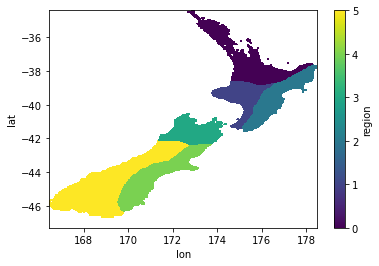

In [20]:
regions_mask['region'].plot()

### defines the number of quantiles we want 

In [21]:
num_quantiles = 3

In [22]:
quant_values = np.linspace(0, 1, num_quantiles + 1, endpoint=True)

In [23]:
quant_values = quant_values[1:-1]

In [24]:
quant_values

array([0.33333333, 0.66666667])

In [25]:
col_labs = [f"Q{int(x)}" for x in (quant_values*100)]

In [26]:
col_labs

['Q33', 'Q66']

In [27]:
list_regions = ['NNI','ENI','WNI','NSI','WSI','ESI'] 

In [28]:
quantiles_dict = {}

for i, region_name in enumerate(list_regions): 

    # create a copy of the original dataset 
    region = dset.copy() 
    
    # get the mask for the region 
    region['mask'] = regions_mask[region_name] 
    
    # multiply the gridded values by the mask 
    region = region[var_name] * region['mask']
        
    # calculate the regional average 
    ts = region.mean(dim=['lat','lon'])
    
    # casts the resulting time-series into a dataframe 
    ts_df = ts.to_dataframe(name=var_name)
    ts_series = ts_df.loc[:,var_name]
    
    # now loop over each month (i.e. season) to calculate the percentiles-based categories
    
    ts_series_cat = []
    
    quantiles_list = []
    
    for month in range(1, 13):
        
        # extract the values for the month 
        ts_series_m = ts_series[ts_series.index.month == month]
        
        # subset to get the climatological period (1981 - 2010)
        clim = ts_series_m.loc['1981':'2010']
        
        # calculates the climatological quantiles 
        quantiles = [clim.quantile(q=q) for q in quant_values.tolist()]
        
        quantiles_list.append(quantiles.copy())
        
        quantiles.insert(0, -np.inf)
        
        quantiles.append(np.inf)
        
        # use [pd.cut](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html) to derive the categories
        ts_series_m_cats = pd.cut(ts_series_m, quantiles, labels=list(range(1, num_quantiles + 1)))
        
        ts_series_cat.append(ts_series_m_cats)
        
        del(quantiles)
     
    quantiles_dict[region_name]  = np.array(quantiles_list)
    
    # concatenate the monthly time-series of quantile categories 
    ts_series_cat = pd.concat(ts_series_cat, axis=0)
    
    # sort in chronological order 
    ts_series_cat = ts_series_cat.sort_index()
    
    # add the column to the dataframe 
    ts_df.loc[:,f'cat_{num_quantiles}'] = ts_series_cat
    
    # calculates the anomalies with respect to the 1981 - 2010 climatology 
    ts_df.loc[:,'anomalies'] = ts_df.loc[:,var_name].groupby(ts_df.index.month).apply(demean)
    
    opath = csv_path.joinpath(f"{big_var}/{region_name}") 
    
    if not opath.exists(): 
        opath.mkdir(parents=True)
        
    # saves the time-series to csv 
    ts_df.to_csv(opath / f'TS_NZ_region_{region_name}_{big_var}_{num_quantiles}_quantiles_anoms_regionmask.csv')
    
    # calculate the descriptive statistics per quantile category, and saves to disk
    ts_df.groupby(ts_df.loc[:,f'cat_{num_quantiles}']).describe().to_csv(opath / f'descriptive_stats_{region_name}__{big_var}_{num_quantiles}_regionmask.csv')
    
    print(f"region {region_name} processed for variable {big_var}")
    

region NNI processed for variable RAIN
region ENI processed for variable RAIN
region WNI processed for variable RAIN
region NSI processed for variable RAIN
region WSI processed for variable RAIN
region ESI processed for variable RAIN


### saves the climatological terciles calculated from the VCSN regional aggregates

In [29]:
quantiles_list = []
for region_name in ['NNI','ENI','WNI','NSI','WSI','ESI']: 
    df = pd.DataFrame(quantiles_dict[region_name])
    df.index = range(1, 13)
    df.index.name = 'season'
    df.columns = pd.MultiIndex.from_product([[region_name],col_labs])
    quantiles_list.append(df)

In [30]:
quantiles_df = pd.concat(quantiles_list, axis=1)

In [31]:
quantiles_df

NNI                     ENI                     WNI  \
               Q33         Q66         Q33         Q66         Q33   
season                                                               
1       285.578719  331.434094  274.071498  321.114051  348.547639   
2       248.614824  332.961545  242.464384  294.581959  295.180472   
3       257.872955  331.864638  252.638276  314.941268  254.790694   
4       280.820774  357.495994  259.313076  345.683910  265.718528   
5       310.691531  383.596231  289.668528  372.407979  320.333417   
6       395.004699  458.729074  318.613320  418.895479  390.115250   
7       429.187813  519.727045  379.785705  454.729255  430.036611   
8       442.625135  540.716362  388.526241  491.319060  426.706083   
9       420.142512  512.264993  372.338652  450.974978  420.091361   
10      366.112610  444.964080  313.277261  379.599113  430.042889   
11      320.408249  391.336021  300.891999  341.651840  390.515556   
12      308.974561  388.192681  272.977726  340.542176  405.116083   

                           NSI                     WSI              \
               Q66         Q33         Q66         Q33         Q66   
season                                                               
1       398.892444  475.969852  574.902207  666.891961  828.101792   
2       360.714583  426.636183  496.996647  631.723299  757.693632   
3       333.436500  381.583990  475.379352  569.079393  691.313376   
4       329.222389  387.624057  487.872897  570.435051  641.627560   
5       365.917083  417.176167  541.006901  612.730836  732.603221   
6       449.128333  512.332188  596.659933  599.421303  719.665989   
7       506.477111  509.858899  627.580330  599.957059  702.473053   
8       536.590472  539.103856  631.099329  578.169024  663.131737   
9       510.486667  508.980469  677.420900  574.940815  688.731551   
10      506.402250  580.510701  689.385806  631.834865  751.095164   
11      467.428417  556.109863  668.662531  635.004418  788.016551   
12      454.167000  561.510673  679.760883  693.675058  841.154451   

               ESI              
               Q33         Q66  
season                          
1       159.669420  187.538355  
2       152.523030  183.801887  
3       144.039688  175.020052  
4       145.346857  179.942113  
5       146.581281  185.115896  
6       141.534597  173.201697  
7       142.917126  186.110407  
8       145.206078  183.140900  
9       130.852727  180.975117  
10      138.864571  181.066667  
11      158.610667  180.487896  
12      165.492606  207.053385

### saves the quantile climatology 

In [32]:
quantiles_df.to_csv(opath.parent / f'Climatological_quantiles_{num_quantiles}_cat_{big_var}_regionmask.csv')

### Now do some comparisons between previous calculations of the tercile categories and the one using regionmask

In [33]:
opath.parent

PosixPath('/home/nicolasf/research/Smart_Ideas/outputs/targets/NZ_regions/NZ_6_regions/RAIN')

In [34]:
for region_name in list_regions: 
    df_orig = pd.read_csv(csv_path.joinpath(f"{big_var}/{region_name}/TS_NZ_region_{region_name}_{big_var}_{num_quantiles}_quantiles_anoms.csv"), index_col=0, parse_dates=True)
    df_reg_mask = pd.read_csv(csv_path.joinpath(f"{big_var}/{region_name}/TS_NZ_region_{region_name}_{big_var}_{num_quantiles}_quantiles_anoms_regionmask.csv"), index_col=0, parse_dates=True)
    print(f"percent matching categories, {big_var}, {region_name} = {(df_orig.cat_3 == df_reg_mask.cat_3).sum() / len(df_orig)}")

percent matching categories, RAIN, NNI = 0.9938775510204082
percent matching categories, RAIN, ENI = 0.9857142857142858
percent matching categories, RAIN, WNI = 0.9836734693877551
percent matching categories, RAIN, NSI = 0.9816326530612245
percent matching categories, RAIN, WSI = 1.0
percent matching categories, RAIN, ESI = 0.9816326530612245
